# Lecture 21: AutoEncoders

In [1]:
import datetime
now = datetime.datetime.now()
print("Version: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Version: 2018-03-19 16:16:14


### This Lecture 

* The basics of AutoEncoders
* This is a complex and very varied subject (could do a whole course on this alone)
* Will not cover supervised pre-training, sparse autoencoder, interpolation


In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
    
import warnings
warnings.filterwarnings('ignore')

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



* Autoencoders are artificial neural networks capable of learning efficient representations of the input data, called codings, without any supervision (i.e., the training set is unlabeled).
* General class of network used to perform data compression, pattern recognition, extracting trends and relations from data 
* Essentially a normal feedforward network except that there are one or more hidden layers with $N_{\rm neuron}<N_{\rm input}$
* Also can be used in an unsupervised (i.e. no training classification) manner to learn features from data 
* they are capable of randomly generating new data that looks very similar to the training data; this is called a generative model.



* autoencoders work by simply learning to copy their inputs to their outputs. This may sound like a trivial task, but we will see that constraining the network in various ways can make it rather difficult.

* type of dimensionality reduction 

Finding 2D representation of 3D data

<img src="Lecture21_Images/ae.jpeg" alt="Drawing" style="width: 500px;"/>

Input mapped to output via an encoder layer


Example build a 3D data set 
<img src="Lecture21_Images/3d.jpeg" alt="Drawing" style="width: 500px;"/>

In [2]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

#normalise the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

Build an Autoencoder

In [3]:
import tensorflow as tf

reset_graph()

n_inputs = 3  # 3D data 
n_hidden = 2  # codings
n_outputs = n_inputs #note that in=out 

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden) #the hidden layer 
outputs = tf.layers.dense(hidden, n_outputs) #output layer 

#define loss function 
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

#train and minimize the loss function
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

In [4]:
init = tf.global_variables_initializer()
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train}) #run 
    
    #look at the codings i.e. the inner representation of the data
    codings_val = codings.eval(feed_dict={X: X_test}) 

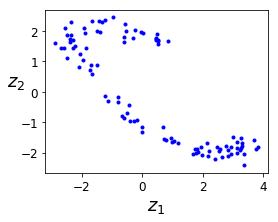

In [5]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

## Stacked autoencoders 

Just like other neural networks we have discussed, autoencoders can have multiple hidden layers. 

In this case they are called stacked autoencoders (or deep autoencoders).


The architecture of a stacked autoencoder is typically symmetrical with regards to the central hidden layer (the coding layer). To put it simply, it looks like a sandwich.

Example (MNIST data, 28x28=784 pixel input)
<img src="Lecture21_Images/stacked.jpeg" alt="Drawing" style="width: 500px;"/>




Let's use the MNIST data as an example

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (ie. 2 stacked Autoencoders). We will use ELU activation, He initialization and L2 regularization.

The code should look very familiar, except that there are no labels (no y)!

In [7]:
reset_graph()

from functools import partial

n_inputs = 28 * 28 #input dimension 
n_hidden1 = 300  #first coding
n_hidden2 = 150  #second coding
n_hidden3 = n_hidden1 #symmetric decoding 
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001 #limit used in L2 reg

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

#Returns an initializer that generates tensors without scaling variance.
#When initializing a deep network, it is in principle advantageous to keep 
#the scale of the input variance constant, so it does not explode or 
#diminish by reaching the final layer. 
he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization

#Returns a function that can be used to apply L2 regularization to weights.
#Small values of L2 can help prevent overfitting the training data.
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

In [8]:
#define a specific dense layer activation using the initialiser and L2 regularisation:
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

#use the user-defined dense layers:
hidden1 = my_dense_layer(X, n_hidden1) #input X to first coding 
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

#define loss finction 
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # not shown in the book

In [9]:
#now train 
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") 
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   
        print("\r{}".format(epoch), "Train MSE:", loss_train)           
        saver.save(sess, "./my_model_all_layers.ckpt")                  

0 Train MSE: 0.020401113
1 Train MSE: 0.01141915
2 Train MSE: 0.010222081
3 Train MSE: 0.009899909
4 Train MSE: 0.010372396


In [10]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})
        
    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


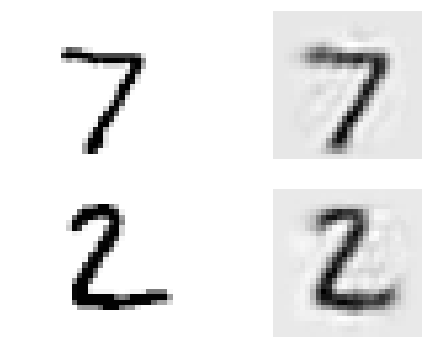

In [11]:
#showing output layer
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")

Can tie decoding weights to be the same as the encoder - difficult to do with dense, but can be coded manually

In [12]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [13]:
activation  = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

In [14]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [15]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 Train MSE: 0.015066669
1 Train MSE: 0.01648836
2 Train MSE: 0.017375693
3 Train MSE: 0.016878149
4 Train MSE: 0.015587544


INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


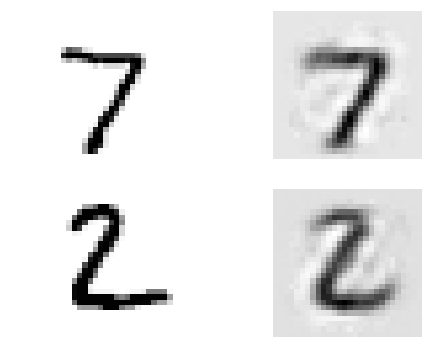

In [16]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

### Training One Autoencoder at a Time 

* Rather than training the whole stacked autoencoder in one go like we just did, 
* It is often much faster to train one shallow autoencoder at a time, 
* then stack all of them into a single stacked autoencoder (hence the name)

<img src="Lecture21_Images/stacked2.jpeg" alt="Drawing" style="width: 500px;"/>




* Can create seperate individual graphs to train each Phase, however this is conceptually straightforward but fairly complicated to code
* Easier to code is to do training within a single graph 

<img src="Lecture21_Images/stacked3.jpeg" alt="Drawing" style="width: 500px;"/>



## Denoising Autoencoder

* Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. 
* This prevents the autoencoder from trivially copying its inputs to its outputs, so it ends up having to find patterns in the data.

* The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched off inputs, just like in dropout

<img src="Lecture21_Images/noise.jpeg" alt="Drawing" style="width: 500px;"/>

#### Gaussian Noise

Simple example (not phased training or weight matching so can user tf.layers.dense)

In [26]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [27]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X)) #adding noise to input 

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,name="hidden2")                           
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu,name="hidden3")  
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs") 

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [28]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [29]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

0 Train MSE: 0.04361849
1 Train MSE: 0.044737797
2 Train MSE: 0.04480146
3 Train MSE: 0.043285184
4 Train MSE: 0.042756647
5 Train MSE: 0.044024773
6 Train MSE: 0.042027753
7 Train MSE: 0.042448957
8 Train MSE: 0.045127917
9 Train MSE: 0.042045258


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_gaussian.ckpt


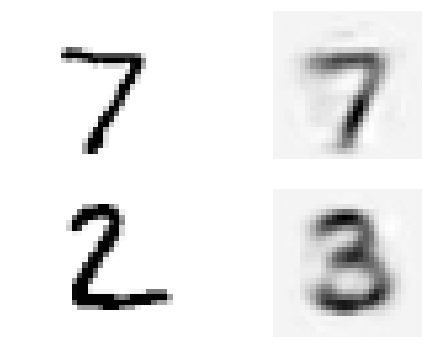

In [30]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_gaussian.ckpt")

Oh dear

#### Dropout 

Simple example (not phased training or weight matching so can user tf.layers.dense)

In [31]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [32]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
#Dropout consists in randomly setting a fraction rate of input units to 0 
#at each update during training time, which helps prevent overfitting.
X_drop = tf.layers.dropout(X, dropout_rate, training=training) #remove based on dropout 

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu, name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") 
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") 
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs") 

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [33]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [34]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_drop.ckpt") 

0 Train MSE: 0.030522909
1 Train MSE: 0.027789451
2 Train MSE: 0.026898954
3 Train MSE: 0.026334498
4 Train MSE: 0.02408395
5 Train MSE: 0.022436682
6 Train MSE: 0.024241244
7 Train MSE: 0.023073534
8 Train MSE: 0.023320826
9 Train MSE: 0.02210321


INFO:tensorflow:Restoring parameters from ./my_model_stacked_drop.ckpt


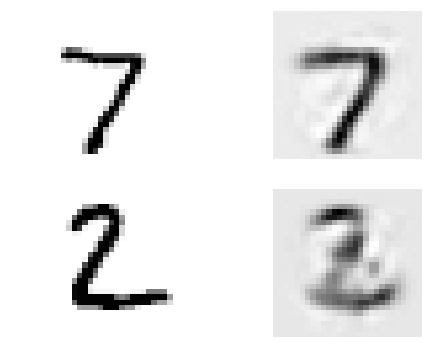

In [35]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_drop.ckpt")

## Variational Autoencoders 

* They are probabilistic autoencoders, meaning that their outputs are partly determined by chance,
* Most importantly, they are generative autoencoders, meaning that they can generate new instances that look like they were sampled from the training set.


* the encoder produces a mean coding μ and a standard deviation σ. 
* The actual coding is then sampled randomly from a Gaussian distribution with mean μ and standard deviation σ.

<img src="Lecture21_Images/var_ae.jpeg" alt="Drawing" style="width: 500px;"/>


Gaussian distribution: during training, the cost function (discussed next) pushes the codings to gradually migrate within the coding space (also called the latent space) to occupy a roughly (hyper) spherical region that looks like a cloud of Gaussian points.


#### Cost Function 

Composed of two parts: 
* The first is the usual reconstruction loss that pushes the autoencoder to reproduce its inputs (e.g. we can use cross entropy for this) 
* The second is the _latent loss_ that pushes the autoencoder to have codings that _look as though they were sampled from a simple Gaussian distribution_, for which we use the KL divergence between the target distribution (the Gaussian distribution) and the actual distribution of the internal codings


In [36]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings, note: very small! 
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])

In [37]:
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)

#create two hidden 3rd layers one for mean and one for std 
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)

#create random noise and add to the third layer, 
#to create a new Gaussian-distributed random third layer (that can be sampled from later)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32) #std=1
hidden3 = hidden3_mean + hidden3_sigma * noise

In [38]:
#normal decoding layers
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)

#final dense layer to generate output for training (sigmoid like softmax)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

In [39]:
#define the loss functions

#normal loss 
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

#latent loss 
#One common variant is to train the encoder to output 
#y = log(σ^2) rather than σ leads to formula used here
eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

#combined loss
loss = reconstruction_loss + latent_loss

In [40]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [41]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train Recon Loss:", reconstruction_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train Recon Loss: 26359.223
1 Train Recon Loss: 26394.412
2 Train Recon Loss: 22548.004
3 Train Recon Loss: 22932.484
4 Train Recon Loss: 21081.22
5 Train Recon Loss: 20597.412
6 Train Recon Loss: 18242.393
7 Train Recon Loss: 16555.898
8 Train Recon Loss: 14524.411
9 Train Recon Loss: 15345.253


INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


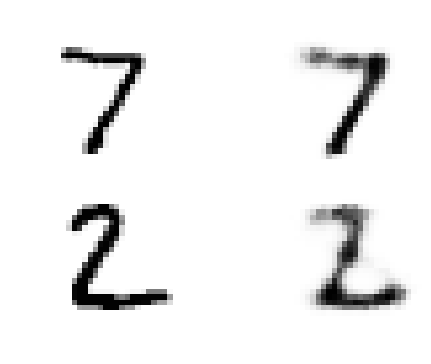

In [42]:
show_reconstructed_digits(X, outputs, "./my_model_variational.ckpt")

In [43]:
### Generating random digits 
n_epochs = 10
batch_size = 150
n_digits = 5 #number of digits to make 
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train Recon Loss:", reconstruction_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")
      
    #create random sampling from the hidden layer and evaluate output with this
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3]) #std=1
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train Recon Loss: 25461.908
1 Train Recon Loss: 21794.875
2 Train Recon Loss: 24429.223
3 Train Recon Loss: 21770.922
4 Train Recon Loss: 20420.734
5 Train Recon Loss: 20496.434
6 Train Recon Loss: 19592.229
7 Train Recon Loss: 16917.04
8 Train Recon Loss: 14977.323
9 Train Recon Loss: 15649.503


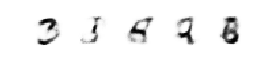

In [44]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

### No Exercise! 

* Instead go through these slides and understand the functionality 
* Also read and look at examples e.g. here https://www.learnopencv.com/understanding-autoencoders-using-tensorflow-python/
    